### Import the processed data

In [4]:
import os
import sys
import pandas as pd

project_root = os.path.abspath(
    os.path.join(os.getcwd(), "../../..")
)  # Adjust '..' if your notebook is deeper
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
try:
    descriptions_df = pd.read_parquet(
        os.path.join(
            project_root, "data", "processed", "cleaned_postings_modeling.parquet"
        )
    )
except FileNotFoundError:
    print(
        "The file 'cleaned_postings_modeling.parquet' was not found. Please check the file path."
    )

    import subprocess

    command = "python3 data/preprocess_data_modeling.py"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    descriptions_df = pd.read_parquet(
        os.path.join(
            project_root, "data", "processed", "cleaned_postings_modeling.parquet"
        )
    )
    if result.returncode != 0:
        print("Error running the command:", result.stderr)
    else:
        print("Command executed successfully:", result.stdout)

descriptions_df

,company_name,title,description,location
0,Corcoran Sawyer Smith,Marketing Coordinator,job description a leading real estate firm in ...,"Princeton, NJ"
1,The National Exemplar,Assitant Restaurant Manager,the national exemplar is accepting application...,"Cincinnati, OH"
2,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,senior associate attorney elder law trusts and...,"New Hyde Park, NY"
3,Downtown Raleigh Alliance,Economic Development and Planning Intern,job summary the economic development planning ...,"Raleigh, NC"
4,Raw Cereal,Producer,company description raw cereal is a creative d...,United States
...,...,...,...,...
122119,Lozano Smith,Title IX/Investigations Attorney,our walnut creek office is currently seeking a...,"Walnut Creek, CA"
122120,Pinterest,"Staff Software Engineer, ML Serving Platform",about pinterest millions of people across the ...,United States
122121,EPS Learning,"Account Executive, Oregon/Washington",company overview eps learning is a leading k 1...,"Spokane, WA"
122122,Trelleborg Applied Technologies,Business Development Manager,the business development manager is a hunter t...,"Texas, United States"


Number of job postings: 122124
Number of columns: 4

Columns in dataset:
- company_name
- title
- description
- location

Missing values by column:
company_name    0
title           0
description     0
location        0
dtype: int64


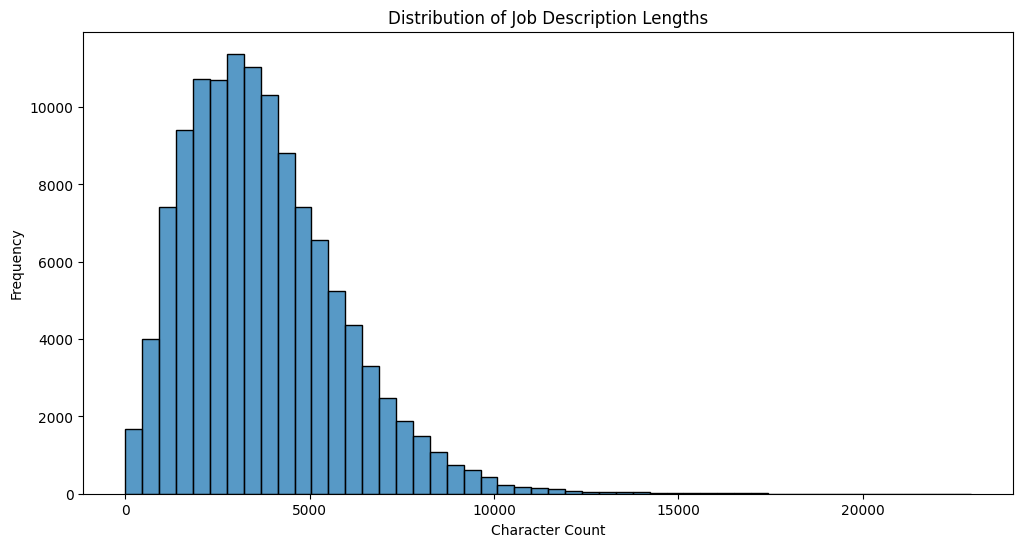

In [6]:
# Basic statistics
print(f"Number of job postings: {len(descriptions_df)}")
print(f"Number of columns: {len(descriptions_df.columns)}")
print("\nColumns in dataset:")
for col in descriptions_df.columns:
    print(f"- {col}")

# Check for missing values
missing_values = descriptions_df.isna().sum()
print("\nMissing values by column:")
print(missing_values)

# Text length distribution
descriptions_df["description_length"] = descriptions_df["description"].str.len()
descriptions_df["title_length"] = descriptions_df["title"].str.len()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(descriptions_df["description_length"], bins=50)
plt.title("Distribution of Job Description Lengths")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

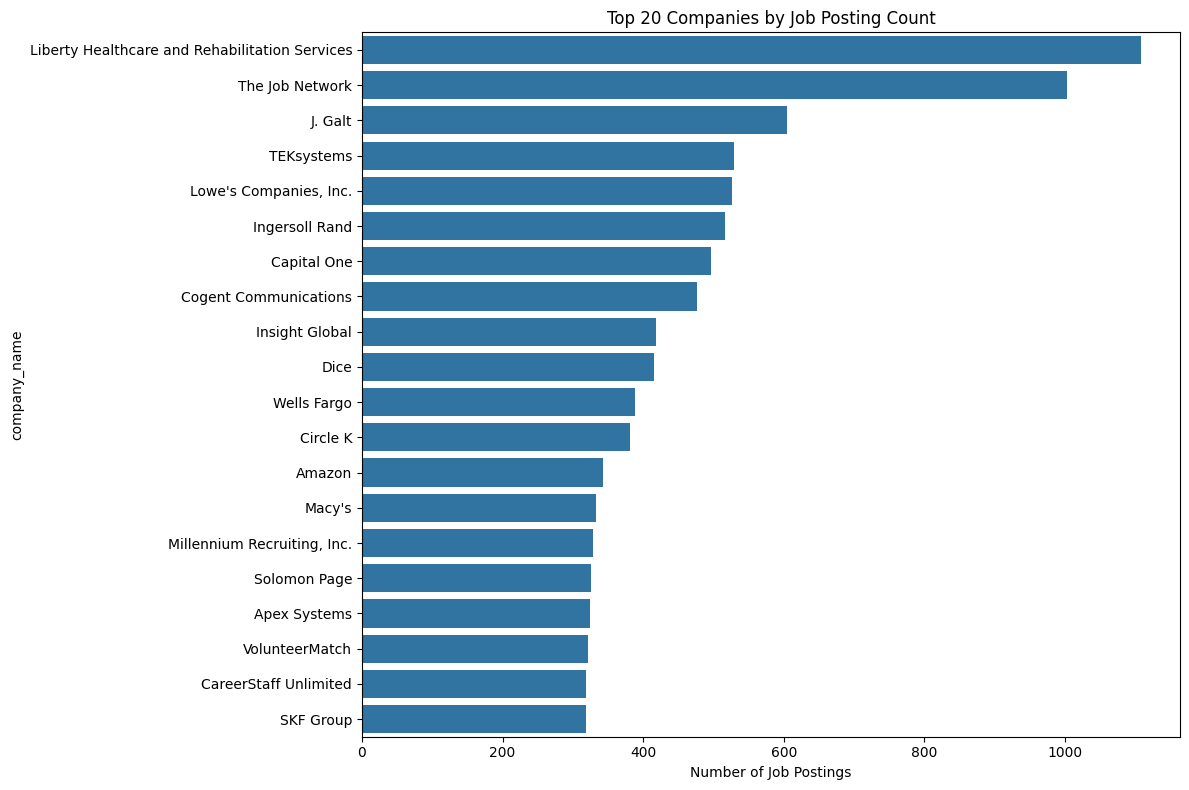

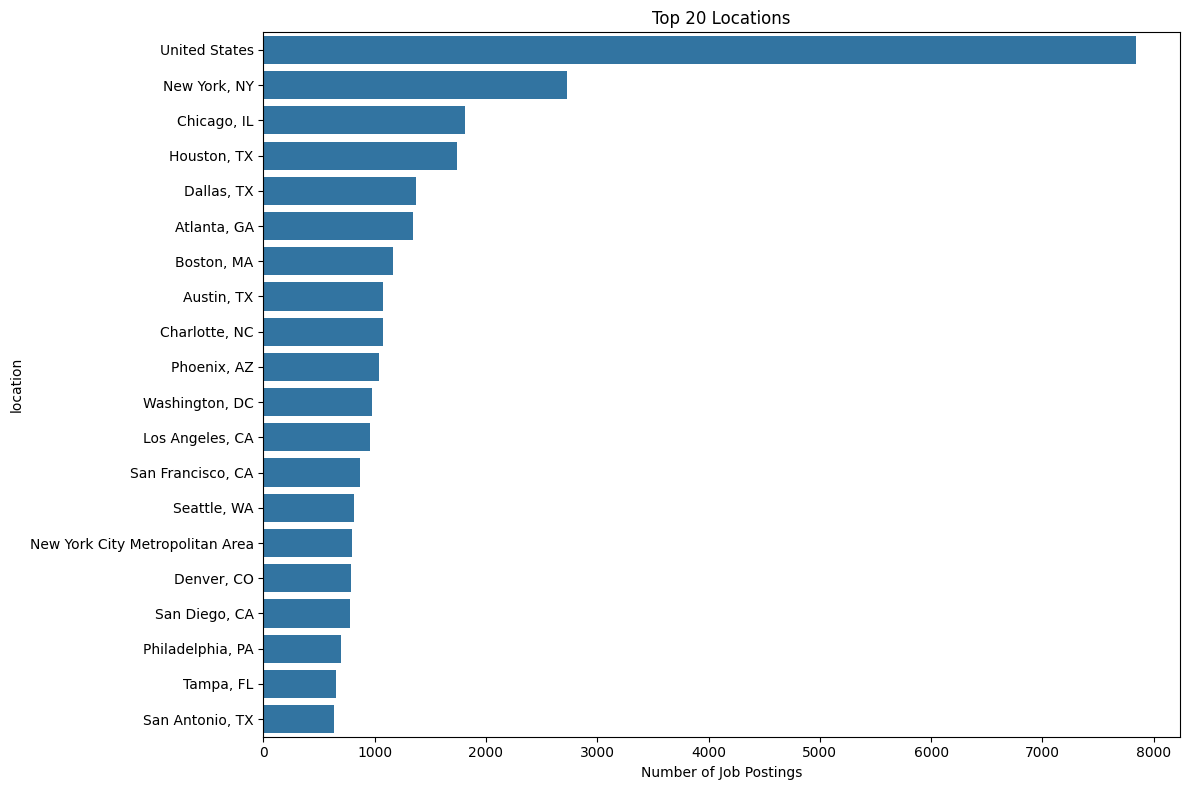

In [7]:
# Top companies by job count
top_companies = descriptions_df["company_name"].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_companies.index, x=top_companies.values)
plt.title("Top 20 Companies by Job Posting Count")
plt.xlabel("Number of Job Postings")
plt.tight_layout()
plt.show()

# Location analysis (if available)
if "location" in descriptions_df.columns:
    location_counts = descriptions_df["location"].value_counts().head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(y=location_counts.index, x=location_counts.values)
    plt.title("Top 20 Locations")
    plt.xlabel("Number of Job Postings")
    plt.tight_layout()
    plt.show()

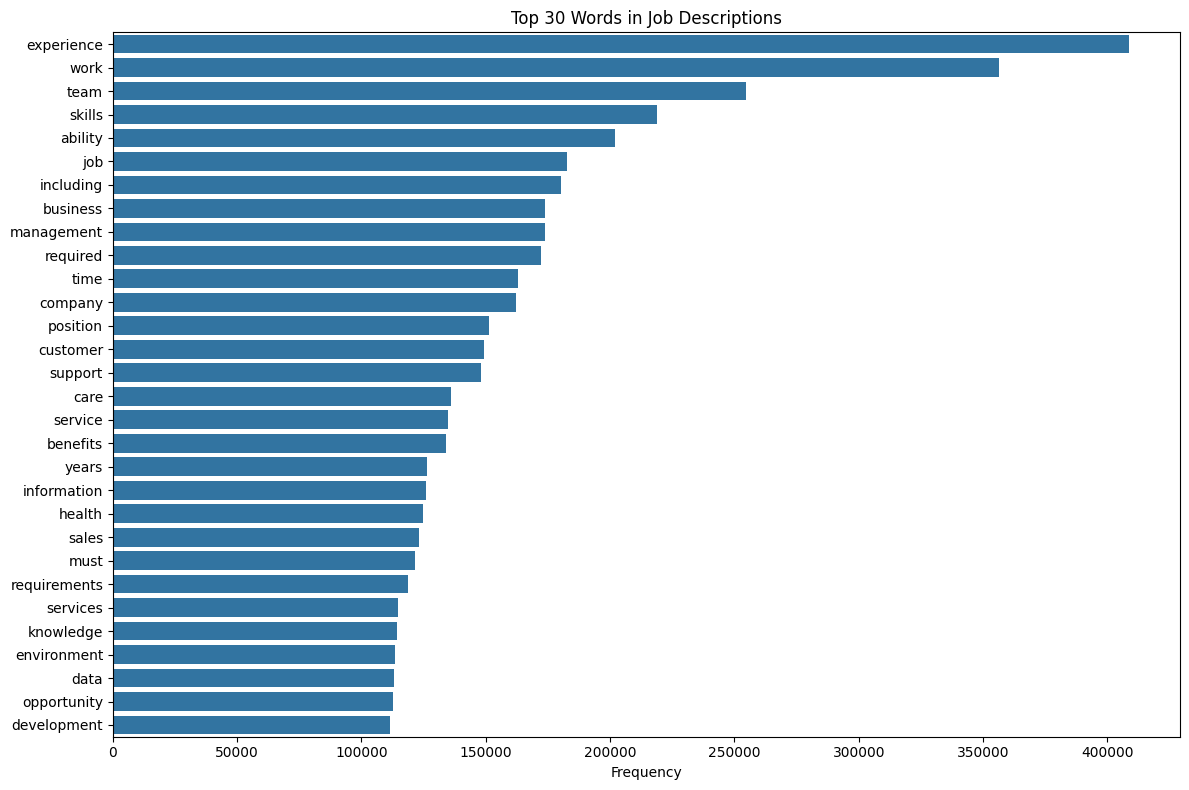

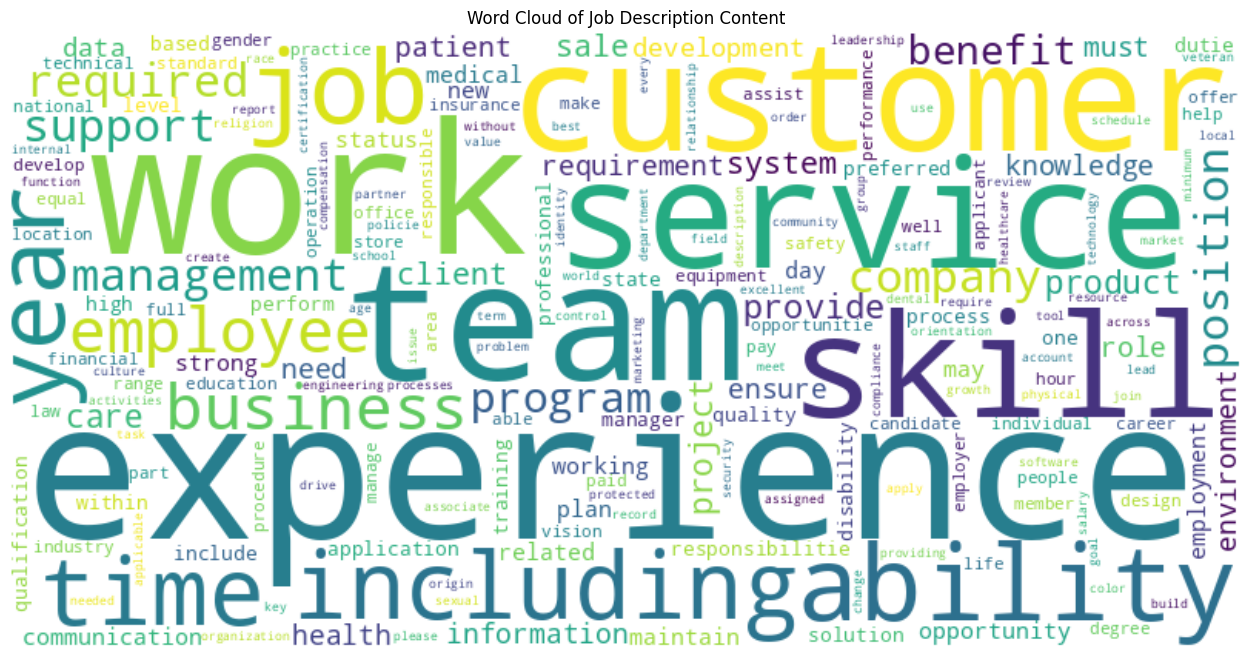

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Download stopwords if not already available
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

stop_words = set(stopwords.words("english"))


# Function to extract words from text
def get_words(text):
    if not isinstance(text, str):
        return []
    # Convert to lowercase and split
    words = re.findall(r"\b[a-zA-Z]{3,}\b", text.lower())
    # Remove stopwords
    return [word for word in words if word not in stop_words]


# Extract common words from descriptions
all_words = []
for desc in descriptions_df["description"].dropna():
    all_words.extend(get_words(desc))

word_freq = Counter(all_words).most_common(30)
words, counts = zip(*word_freq)

plt.figure(figsize=(12, 8))
sns.barplot(y=words, x=counts)
plt.title("Top 30 Words in Job Descriptions")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Word cloud visualization
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800, height=400, background_color="black", max_words=50, collocations=False
).generate(" ".join(all_words))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Job Description Content")
plt.show()

In [ ]:
# Analyze job titles
title_words = []
for title in descriptions_df["title"].dropna():
    title_words.extend(get_words(title))

title_freq = Counter(title_words).most_common(30)
t_words, t_counts = zip(*title_freq)

plt.figure(figsize=(12, 8))
sns.barplot(y=t_words, x=t_counts)
plt.title("Top 30 Words in Job Titles")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


# Job role categories (extract from titles)
def categorize_role(title):
    title = title.lower()
    if any(role in title for role in ["senior", "sr", "lead", "principal"]):
        return "Senior"
    elif any(role in title for role in ["manager", "head", "director"]):
        return "Management"
    elif any(role in title for role in ["junior", "jr", "entry"]):
        return "Junior"
    else:
        return "Mid-level"


descriptions_df["role_level"] = descriptions_df["title"].apply(categorize_role)
role_counts = descriptions_df["role_level"].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(role_counts, labels=role_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Job Seniority Levels")
plt.axis("equal")
plt.show()

In [ ]:
# Function to check for common skills in text
tech_skills = [
    "python",
    "java",
    "javascript",
    "sql",
    "aws",
    "cloud",
    "docker",
    "kubernetes",
    "react",
    "angular",
    "node",
    "tensorflow",
    "pytorch",
    "machine learning",
    "ai",
    "data science",
    "analytics",
]


def extract_skills(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    found_skills = [skill for skill in tech_skills if skill in text]
    return found_skills


descriptions_df["skills"] = descriptions_df["description"].apply(extract_skills)

# Count skill occurrences
skill_counts = Counter(
    [skill for skills in descriptions_df["skills"] for skill in skills]
)
skill_df = pd.DataFrame(skill_counts.items(), columns=["Skill", "Count"]).sort_values(
    by="Count", ascending=False
)

plt.figure(figsize=(12, 8))
sns.barplot(data=skill_df, y="Skill", x="Count")
plt.title("Common Technical Skills in Job Descriptions")
plt.xlabel("Number of Mentions")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the text data
descriptions = descriptions_df["description"].fillna("").tolist()

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words="english", max_features=1000
)
tfidf = tfidf_vectorizer.fit_transform(descriptions)

# Create an LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf)


# Function to print topics
def print_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_terms = [
            feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]
        ]
        topics.append((topic_idx, topic_terms))
        print(f"Topic #{topic_idx}:")
        print(", ".join(topic_terms))
        print()
    return topics


# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print topics
print("Topics found via LDA:")
topics = print_top_words(lda, feature_names, 10)

In [ ]:
import textstat

# Calculate readability scores
descriptions_df["flesch_reading_ease"] = descriptions_df["description"].apply(
    lambda x: textstat.flesch_reading_ease(x) if isinstance(x, str) else None
)

descriptions_df["gunning_fog"] = descriptions_df["description"].apply(
    lambda x: textstat.gunning_fog(x) if isinstance(x, str) else None
)

# Plot readability distributions
plt.figure(figsize=(12, 6))
sns.histplot(descriptions_df["flesch_reading_ease"].dropna(), bins=30)
plt.title("Flesch Reading Ease Score Distribution")
plt.xlabel("Score (Higher = Easier to Read)")
plt.axvline(x=60, color="r", linestyle="--", label="Easy to Read Threshold")
plt.legend()
plt.show()